# Introduction
* ASHRAE - Great Energy Predictor III<br>
評価することは、建物が改善なしでどれだけのエネルギーを使用したかを真に知る方法がないため、難しい場合があります。最善の方法は、反事実モデルを構築することです。建物がオーバーホールされると、新しい（より低い）エネルギー消費量が元の建物のモデル化された値と比較され、改装による節約が計算されます。より正確なモデルは、より良い市場インセンティブをサポートし、低コストの資金調達を可能にします。
<br>
この競争では、過去の使用率と観測された天気に基づいて、4つのエネルギータイプにわたってこれらの反事実モデルを構築することが求められます。このデータセットには、世界中のさまざまなサイトの1,000を超える建物からの3年間の1時間ごとのメーター測定値が含まれています。

# Import packages

In [87]:
# パッケージのインポート
import numpy as np
import pandas as pd
import datetime
import math
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from typing import Dict, List

import hyperopt
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error

from IPython.display import display # Allows the use of display() for DataFrames
from IPython.core.display import display, HTML

from pylab import rcParams
import matplotlib.font_manager as fm
import warnings

warnings.filterwarnings("ignore")
display(HTML("<style>.container { width:80% !important; }</style>")) # 表示画面サイズ変更

# ①日本語を表示するためのフォントの指定
# print([f.name for f in fm.fontManager.ttflist])
# ②日本語フォントがない場合
# print(matplotlib.matplotlib_fname())
# ③上記で表示されたフォルダのパスの途中(.../mpl-data/fonts/ttf)に.ttfを格納し、下記を実行
# print(matplotlib.get_cachedir())
# ④上記フォルダ内の"fontlist~.json"を削除して下記でリビルド
# matplotlib.font_manager._rebuild()
# ⑤フォントの一覧に.ttfで追加したフォントが表示されるはず

In [88]:
# matplotlibの設定
rcParams["figure.figsize"] = (10, 6)
sns.set(style="whitegrid", font=["IPAPGothic"], font_scale=1.0)

# Read data & FE

train.csv<br>
* building_id：建物のメタデータの外部キー<br>
* meter：メーターIDコード。 {0：電気、1：冷水、2：蒸気、3：温水}と読みます。すべての建物にすべてのメータータイプがあるわけではありません。<br>
* timestamp：測定が行われたとき<br>
* meter_reading：ターゲット変数。 kWh（または同等の）単位のエネルギー消費。これは、測定誤差のある実際のデータであり、モデリング誤差のベースラインレベルを課すと予想されます。<br>

building_meta.csv<br>
* site_id：気象ファイルの外部キー。<br>
* building_id：training.csvの外部キー<br>
* primary_use：EnergyStarプロパティタイプの定義に基づいた、建物の主要な活動カテゴリのインジケータ<br>
* square_feet：建物の総床面積<br>
* year_built：年の建物が開かれた<br>
* floor_count：建物の階数<br>

weather_ train / test.csv<br>
サイトに可能な限り近い気象観測所からの気象データ。<br>
* site_id<br>
* air_temperature：摂氏<br>
* cloud_coverage：オクタスの雲に覆われた空の部分<br>
* dew_temperature：摂氏<br>
* precip_depth_1_hr：ミリメートル<br>
* sea_level_pressure：ミリバール/ヘクトパスカル<br>
* wind_direction：コンパスの方向（0-360）<br>
* wind_speed：メートル毎秒<br>

test.csv<br>
提出ファイルは、ファイルのアップロードのスペースを節約するために、IDコードに行番号を使用します。 test.csvには機能データがありません。予測を正しい順序で取得できるように存在します。
* row_id：提出ファイルの行ID<br>
* building_id：建物IDコード<br>
* meter：メーターIDコード<br>
* timestamp：テストデータ期間のタイムスタンプ<br>

sample_submission.csv<br>
有効なサンプル提出。<br>

ソリューションファイル内のすべての浮動小数点は、小数点以下4桁に切り捨てられました。ファイルアップロードのスペースを節約するために同じことを行うことをお勧めします。
トレインセットとテストセットの両方のメーターの読み取り値の一部にギャップがあります。テストセットのギャップは明らかにされず、スコアも付けられません。

In [89]:
train_df = pd.read_csv("data/train.csv")
train_df

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [90]:
test_df = pd.read_csv("data/test.csv")
test_df

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00
...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00
41697596,41697596,1445,0,2018-05-09 07:00:00
41697597,41697597,1446,0,2018-05-09 07:00:00
41697598,41697598,1447,0,2018-05-09 07:00:00


In [91]:
building_meta_df = pd.read_csv("data/building_metadata.csv")
building_meta_df

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [92]:
weather_train_df = pd.read_csv("data/weather_train.csv")
weather_train_df

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


In [93]:
weather_test_df = pd.read_csv("data/weather_test.csv")
weather_test_df

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6
...,...,...,...,...,...,...,...,...,...
277238,15,2018-12-31 19:00:00,3.3,NaN,1.7,NaN,1018.3,150.0,7.7
277239,15,2018-12-31 20:00:00,2.8,NaN,1.1,NaN,1017.8,140.0,5.1
277240,15,2018-12-31 21:00:00,2.8,NaN,1.7,-1.0,1017.2,140.0,6.2
277241,15,2018-12-31 22:00:00,2.8,NaN,2.2,8.0,1016.1,140.0,5.1


In [94]:
def make_is_bad_zero(Xy_subset, min_interval=48, summer_start=3000, summer_end=7500):
    """Helper routine for 'find_bad_zeros'.
    
    This operates upon a single dataframe produced by 'groupby'. We expect an 
    additional column 'meter_id' which is a duplicate of 'meter' because groupby 
    eliminates the original one."""
    meter = Xy_subset.meter_id.iloc[0]
    is_zero = Xy_subset.meter_reading == 0
    if meter == 0:
        # Electrical meters should never be zero. Keep all zero-readings in this table so that
        # they will all be dropped in the train set.
        return is_zero

    transitions = (is_zero != is_zero.shift(1))
    all_sequence_ids = transitions.cumsum()
    ids = all_sequence_ids[is_zero].rename("ids")
    if meter in [2, 3]:
        # It's normal for steam and hotwater to be turned off during the summer
        keep = set(ids[(Xy_subset.timestamp < summer_start) |
                       (Xy_subset.timestamp > summer_end)].unique())
        is_bad = ids.isin(keep) & (ids.map(ids.value_counts()) >= min_interval)
    elif meter == 1:
        time_ids = ids.to_frame().join(Xy_subset.timestamp).set_index("timestamp").ids
        is_bad = ids.map(ids.value_counts()) >= min_interval

        # Cold water may be turned off during the winter
        jan_id = time_ids.get(0, False)
        dec_id = time_ids.get(8283, False)
        if (jan_id and dec_id and jan_id == time_ids.get(500, False) and
                dec_id == time_ids.get(8783, False)):
            is_bad = is_bad & (~(ids.isin(set([jan_id, dec_id]))))
    else:
        raise Exception(f"Unexpected meter type: {meter}")

    result = is_zero.copy()
    result.update(is_bad)
    return result

def find_bad_zeros(X, y):
    """Returns an Index object containing only the rows which should be deleted."""
    Xy = X.assign(meter_reading=y, meter_id=X.meter)
    is_bad_zero = Xy.groupby(["building_id", "meter"]).apply(make_is_bad_zero)
    return is_bad_zero[is_bad_zero].index.droplevel([0, 1])

def find_bad_sitezero(X):
    """Returns indices of bad rows from the early days of Site 0 (UCF)."""
    return X[(X.timestamp < 3378) & (X.site_id == 0) & (X.meter == 0)].index

def find_bad_building1099(X, y):
    """Returns indices of bad rows (with absurdly high readings) from building 1099."""
    return X[(X.building_id == 1099) & (X.meter == 2) & (y > 3e4)].index

def find_bad_rows(X, y):
    return find_bad_zeros(X, y).union(find_bad_sitezero(X)).union(find_bad_building1099(X, y))

In [95]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # TODO: categoryとdatetimeの分岐
        #else:
        #    df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [96]:
# bad_rows = find_bad_rows(X, y)
# pd.Series(bad_rows.sort_values()).to_csv("rows_to_drop.csv", header=False, index=False)

In [97]:
# eliminate bad rows
bad_rows = pd.read_csv("rows_to_drop.csv")
train_df.drop(bad_rows.loc[:, "0"], inplace = True)
train_df.reset_index(drop = True, inplace = True)

In [98]:
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df["timestamp"].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df["timestamp"].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df["site_id"] == site_id]["timestamp"])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=["timestamp"])
        new_rows["site_id"] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(["site_id","day","month"])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(["site_id","day","month"])["air_temperature"].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(["site_id","day","month"])["cloud_coverage"].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method="ffill"),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(["site_id","day","month"])["dew_temperature"].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(["site_id","day","month"])["sea_level_pressure"].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method="ffill"),columns=["sea_level_pressure"])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(["site_id","day","month"])["wind_direction"].mean(),columns=["wind_direction"])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(["site_id","day","month"])["wind_speed"].mean(),columns=["wind_speed"])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(["site_id","day","month"])["precip_depth_1_hr"].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method="ffill"),columns=["precip_depth_1_hr"])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(["datetime","day","week","month"],axis=1)
        
    return weather_df

In [99]:
# case04 small fe change
def features_engineering(df):
        
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df["square_feet"] =  np.log1p(df["square_feet"])
    
    # Remove Unused Columns
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [100]:
weather_train_df = fill_weather_dataset(weather_train_df)
weather_test_df = fill_weather_dataset(weather_test_df)

In [101]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
building_meta_df = reduce_mem_usage(building_meta_df)
weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)

Memory usage of dataframe is 580.86 MB
Memory usage after optimization is: 272.28 MB
Decreased by 53.1%
Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 596.49 MB
Decreased by 53.1%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.03 MB
Decreased by 60.3%
Memory usage of dataframe is 9.65 MB
Memory usage after optimization is: 3.08 MB
Decreased by 68.1%
Memory usage of dataframe is 19.25 MB
Memory usage after optimization is: 6.15 MB
Decreased by 68.1%


In [102]:
train_df = train_df.merge(building_meta_df, left_on="building_id", right_on="building_id", how="left")
train_df = train_df.merge(weather_train_df, how="left", left_on=["site_id", "timestamp"], right_on=["site_id", "timestamp"])
del weather_train_df
gc.collect()

0

In [103]:
test_df = test_df.merge(building_meta_df, left_on="building_id", right_on="building_id", how="left")
test_df = test_df.merge(weather_test_df, how="left", left_on=["site_id", "timestamp"], right_on=["site_id", "timestamp"])
del weather_test_df
gc.collect()

20

In [104]:
train_df = features_engineering(train_df)
test_df = features_engineering(test_df)

In [105]:
train_df

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekend
0,0,0,0.000000,0,0,8.913685,25.000000,6.0,20.000000,-0.17395,0,4
1,105,0,23.303600,1,0,10.832181,3.800781,0.0,2.400391,0.00000,0,4
2,106,0,0.374600,1,0,8.589514,3.800781,0.0,2.400391,0.00000,0,4
3,106,3,0.000000,1,0,8.589514,3.800781,0.0,2.400391,0.00000,0,4
4,107,0,175.184006,1,0,11.487946,3.800781,0.0,2.400391,0.00000,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
19033521,1443,0,64.949997,15,0,10.604404,1.700195,2.0,-5.601562,-1.00000,23,5
19033522,1444,0,8.750000,15,1,9.884305,1.700195,2.0,-5.601562,-1.00000,23,5
19033523,1445,0,4.825000,15,0,8.366138,1.700195,2.0,-5.601562,-1.00000,23,5
19033524,1447,0,159.574997,15,4,10.301458,1.700195,2.0,-5.601562,-1.00000,23,5


In [106]:
test_df

,row_id,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekend
0,0,0,0,0,0,8.913685,17.796875,4.000000,11.703125,0.282715,0,6
1,1,1,0,0,0,7.908755,17.796875,4.000000,11.703125,0.282715,0,6
2,2,2,0,0,0,8.589886,17.796875,4.000000,11.703125,0.282715,0,6
3,3,3,0,0,0,10.072639,17.796875,4.000000,11.703125,0.282715,0,6
4,4,4,0,0,0,11.666573,17.796875,4.000000,11.703125,0.282715,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
41697595,41697595,1444,0,15,1,9.884305,12.031250,1.727539,3.355469,-1.000000,7,2
41697596,41697596,1445,0,15,0,8.366138,12.031250,1.727539,3.355469,-1.000000,7,2
41697597,41697597,1446,0,15,1,9.329545,12.031250,1.727539,3.355469,-1.000000,7,2
41697598,41697598,1447,0,15,4,10.301458,12.031250,1.727539,3.355469,-1.000000,7,2


# CV strategy

In [107]:
N_FOLDS = 3 # set folds for out-of-fold prediction
kf = KFold(n_splits=N_FOLDS, shuffle=False)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=False)
tss = TimeSeriesSplit(n_splits=N_FOLDS, max_train_size=None)
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

# LightGBM

In [108]:
X_train = train_df.drop("meter_reading", axis=1)
y_train = np.log1p(train_df["meter_reading"])
ID_test = test_df["row_id"]
X_test = test_df.drop(["row_id"], axis=1)
del train_df, test_df
gc.collect()

80

In [109]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(10, 15))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title("feature importance(gain)")
    plt.tight_layout()
    plt.show()
    #plt.savefig("lgbm_importances.png")

In [110]:
def hyperopt_lightgbm(X: pd.DataFrame, y: pd.Series):
    X_tra, X_val, y_tra, y_val = train_test_split(X, y, test_size=0.5, shuffle=False)
    train_data = lgb.Dataset(X_tra, label=y_tra)
    valid_data = lgb.Dataset(X_val, label=y_val)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "num_threads": 4,
    }
    
    space = {
        #"boosting_type": hp.choice("boosting_type", ["gbdt", "dart"]),
        "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.05)),
        "max_depth": hp.choice("max_depth", np.arange(3, 6, dtype=int)),
        "num_leaves": hp.choice("num_leaves", np.linspace(2, 32, 2, dtype=int)),
        "feature_fraction": hp.quniform("feature_fraction", 0.5, 1.0, 0.1),
        "bagging_fraction": hp.quniform("bagging_fraction", 0.5, 1.0, 0.1),
        "bagging_freq": hp.choice("bagging_freq", np.linspace(0, 50, 10, dtype=int)),
        "reg_alpha": hp.quniform("reg_alpha", 1, 2, 0.1),
        "reg_lambda": hp.quniform("reg_lambda", 1, 2, 0.1),
        "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
        #"min_data_in_leaf": hp.choice("min_data_in_leaf", np.linspace(0, 20, 10, dtype=int)),
    }

    def objective(hyperparams):
        model = lgb.train(params={**params, **hyperparams},
                          train_set=train_data,
                          num_boost_round=300,
                          valid_sets=valid_data,
                          early_stopping_rounds=30,
                          verbose_eval=0)
        
        score = model.best_score["valid_0"]["rmse"]
        return {"loss": score, "status": STATUS_OK}

    trials = Trials()
    best = hyperopt.fmin(fn=objective, space=space, trials=trials,
                         algo=tpe.suggest, max_evals=10, verbose=1,
                         rstate=np.random.RandomState(1))

    lgb_params = space_eval(space, best) 
        
    print("lgb_params = {0}".format({**params, **lgb_params}))
    
    return {**params, **lgb_params}

In [73]:
from bayes_opt import BayesianOptimization

def lgb_best_params(X, y, opt_params, init_points=2, optimization_round=20, n_folds=3, random_seed=0, cv_estimators=1000):
    
    # prepare dataset
    train_data = lgb.Dataset(data=X, label=y, categorical_feature = categorical, free_raw_data=False)
    
    def lgb_run(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight,learning_rate):
        params = {"boosting": "gbdt","application":"regression","num_iterations":cv_estimators, "early_stopping_round":int(cv_estimators/5), "metric":"rmse"}
        params["num_leaves"] = int(round(num_leaves))
        params["feature_fraction"] = max(min(feature_fraction, 1), 0)
        params["bagging_fraction"] = max(min(bagging_fraction, 1), 0)
        params["max_depth"] = int(round(max_depth))
        params["lambda_l1"] = max(lambda_l1, 0)
        params["lambda_l2"] = max(lambda_l2, 0)
        params["min_split_gain"] = min_split_gain
        params["min_child_weight"] = min_child_weight
        params["learning_rate"] = learning_rate
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=False, verbose_eval=cv_estimators, metrics=["rmse"])
        return -min(cv_result["rmse-mean"])
    
    params_finder = BayesianOptimization(lgb_run, opt_params, random_state=2021)
    # optimize
    params_finder.maximize(init_points=init_points, n_iter=optimization_round)

    # return best parameters
    return params_finder.max

In [74]:
fold = 5

# Hyperparameter range
params_range = {
    "num_leaves": (1000, 3000),
    "feature_fraction": (0.7, 0.9),
    "bagging_fraction": (0.8, 1),
    "max_depth": (8, 15),
    "lambda_l1": (2, 5),
    "lambda_l2": (2, 5),
    "min_split_gain": (0.001, 0.1),
    "min_child_weight": (5, 50),
    "learning_rate" : (.03,.07)
}

# You can experiments with different estimators in a single execution. I"m using small numbers for demonstration purpose so you must change to high numbers.
cv_estimators = [50, 100, 200]

#n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
optimization_round = 10 # Simply, 10 models with different parameter will be tested. And the best one will be returned.

#init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
init_points = 2

random_seed = 2010

best_params= []
for cv_estimator in cv_estimators:
    opt_params = lgb_best_params(X_train, y_train, params_range, init_points=init_points, optimization_round=optimization_round, n_folds=fold, random_seed=random_seed, cv_estimators=cv_estimator)
    opt_params["params"]["iteration"] = cv_estimator
    opt_params["params"]["fold"] = fold
    opt_params["params"]["rmse"] = opt_params["target"]
    best_params.append(opt_params["params"])

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [111]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
lgb_params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

Fold 0
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.669041	valid's rmse: 0.820172
[200]	train's rmse: 0.614839	valid's rmse: 0.817397
Early stopping, best iteration is:
[155]	train's rmse: 0.630637	valid's rmse: 0.816847


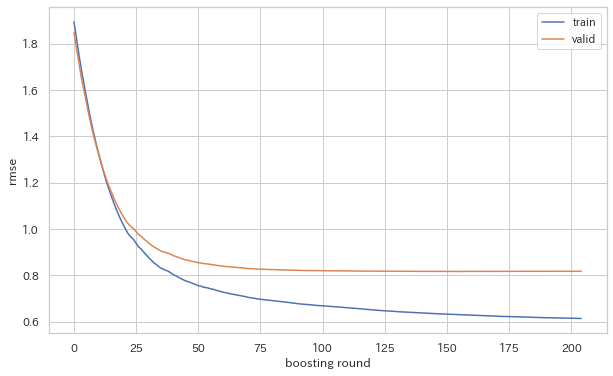

Fold 1
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.672412	valid's rmse: 0.792897
[200]	train's rmse: 0.621281	valid's rmse: 0.780599
Early stopping, best iteration is:
[230]	train's rmse: 0.614668	valid's rmse: 0.779863


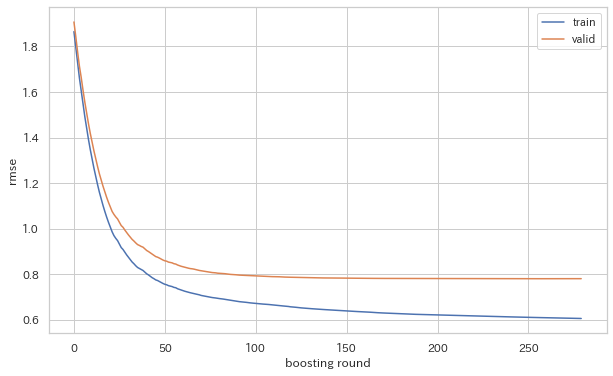

Fold 2
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.635395	valid's rmse: 0.852507
Early stopping, best iteration is:
[125]	train's rmse: 0.612535	valid's rmse: 0.850666


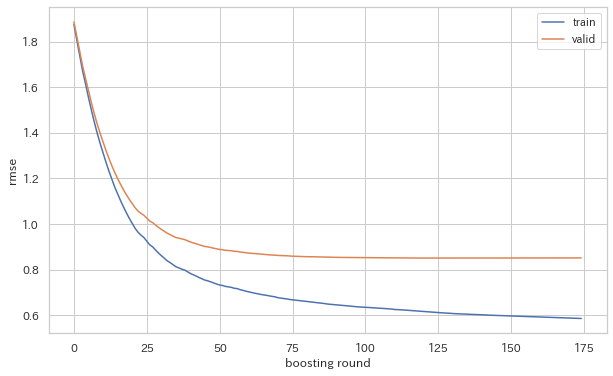

OOF valid: rmse_score=0.8163034992136908
Wall time: 34min 56s


In [112]:
%%time
lgb_oof_train = np.zeros((ntrain,))
lgb_oof_test = np.zeros((ntest,))
lgb_oof_test_skf = np.empty((N_FOLDS, ntest))
lgb_feature_importances = pd.DataFrame(X_train.columns, columns=["feature"])

#for i, (train_index, valid_index) in enumerate(kf.split(X_train)):
for i, (train_index, valid_index) in enumerate(skf.split(X_train, X_train["building_id"])):
#for i, (train_index, valid_index) in enumerate(tss.split(X_train)):
    print("Fold " + str(i))

    X_tra, y_tra = X_train.iloc[train_index], y_train.iloc[train_index]
    X_val, y_val = X_train.iloc[valid_index], y_train.iloc[valid_index]

    train_data = lgb.Dataset(X_tra, label=y_tra, categorical_feature=categorical_features)
    valid_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features)

    evaluation_results = {}
    lgbm = lgb.train(params={**lgb_params},
                     train_set=train_data,
                     num_boost_round=1000,
                     valid_sets=[train_data, valid_data],
                     valid_names=["train", "valid"],
                     evals_result=evaluation_results,
                     early_stopping_rounds=50,
                     verbose_eval=100)

    oof_fi = pd.DataFrame(lgbm.feature_importance(importance_type="gain"), columns=["Fold " + str(i)])
    oof_fi["feature"] = X_tra.columns
    lgb_feature_importances = pd.merge(lgb_feature_importances, oof_fi, on="feature")

    pred_val = lgbm.predict(X_val, num_iteration=lgbm.best_iteration)
    pred_test = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)

    lgb_oof_train[valid_index] = pred_val
    lgb_oof_test_skf[i, :] = np.expm1(pred_test)

    # Plot the QWK during training
    plt.plot(evaluation_results["train"]["rmse"], label="train")
    plt.plot(evaluation_results["valid"]["rmse"], label="valid")
    plt.ylabel("rmse")
    plt.xlabel("boosting round")
    plt.legend()
    plt.show()

print("OOF valid: rmse_score=" + str(np.sqrt(mean_squared_error(y_train, lgb_oof_train))))
lgb_oof_test[:] = lgb_oof_test_skf.mean(axis=0)

In [113]:
# case03 3kf OOF valid: rmse_score=1.0980998484688145 1.089
# case03 3skf OOF valid: rmse_score=1.0900821262210436 1.089
# case03 3tss 1.16483
# case03 5skf OOF valid: rmse_score=1.0311544041854734 1.097

# case04 5skf OOF valid: rmse_score=0.7803897409395618 1.102
# case04 5skf small fe change OOF valid: rmse_score=0.7831480155486338 1.108
# case04 3skf OOF valid: rmse_score=0.8163034992136908

In [75]:
# for TimeSeriesSplit
# clf right now is the last model, trained with 80% of data and validated with 20%
clf = lgb.LGBMRegressor(**lgb_params, num_boost_round=lgbm.best_iteration)
clf.fit(X_train, y_train)

LGBMRegressor(boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.85,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1,
              num_boost_round=71, num_leaves=1280, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=2, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [78]:
lgb_oof_test = np.expm1(clf.predict(X_test))

In [114]:
results_df = pd.DataFrame({"row_id": ID_test, "meter_reading": np.clip(lgb_oof_test, 0, a_max=None)})
results_df

,row_id,meter_reading
0,0,130.243107
1,1,60.392220
2,2,7.374016
3,3,270.671847
4,4,1413.081054
...,...,...
41697595,41697595,6.255767
41697596,41697596,4.139351
41697597,41697597,7.127778
41697598,41697598,180.959023


In [115]:
results_df.to_csv("submission_case04_3skf_clean.csv", index=False)